In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.optim as optim
from torch.autograd import Variable
import logging
import time
from torch.utils.data import DataLoader
from PIL import Image
from models.TrustworthySeg import TMSU
from data.transform import ISIC2018_transform,LiTS2017_transform,DRIVE2004_transform,TOAR2019_transform,HC_2018_transform
from data.BraTS2019 import BraTS
from data.Autopet2023 import Autopet, Autopet2 # anissa: added this

# from data.ISIC2018 import ISIC|
# from data.COVID19 import Covid
# from data.CHAOS20 import CHAOS
# from data.LiTS17 import LiTS
# from data.DRIVE04 import DRIVE
# from data.TOAR19 import TOAR
# from data.HC2018 import HC

import cv2
from thop import profile
from models.criterions import get_soft_label
from predict import tailor_and_concat,RandomMaskingGenerator,softmax_output_litsdice,softmax_output_litshd,softmax_assd_litsscore,softmax_mIOU_litsscore,Uentropy_our,cal_ueo,cal_ece_our,softmax_mIOU_score,softmax_output_dice,softmax_output_hd,dice_isic,iou_isic,HD_isic,Dice_isic,IOU_isic,softmax_assd_score
from binary import assd,hd95
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import argparse
import nibabel as nib
import imageio
from plot import loss_plot,metrics_plot
from tensorboardX import SummaryWriter

torch.cuda.empty_cache()

In [2]:

def getArgs():
    local_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    parser = argparse.ArgumentParser()
    # Basic Information
    parser.add_argument('--user', default='anissa', type=str)
    parser.add_argument('--experiment', default='UMIS', type=str) # BraTS ISIC COVID
    parser.add_argument('--date', default=local_time.split(' ')[0], type=str)
    parser.add_argument('--description',
                        default='Trustworthy medical image segmentation by coco,'
                                'training on train.txt!',
                        type=str)
    # training detalis
    parser.add_argument('--start_epoch', type=int, default=1, metavar='N',
                        help='number of epochs to train [default: 500]')
    parser.add_argument('--end_epochs', type=int, default=200, metavar='N',
                        help='number of epochs to train [default: 200]')
    parser.add_argument('--submission', default='./results', type=str)

    parser.add_argument('--lambda-epochs', type=int, default=50, metavar='N',
                        help='gradually increase the value of lambda from 0 to 1')
    parser.add_argument('--save_freq', default=5, type=int)
    parser.add_argument('--lr', type=float, default=0.0002, metavar='LR',
                        help='learning rate')# BraTS: 0.0002 # ISIC: 0.0002
    # DataSet Information
    parser.add_argument('--savepath', default='./results/plot/output', type=str)
    parser.add_argument('--save_dir', default='./results', type=str)
    parser.add_argument("--mode", default="train", type=str, help="train/test/train&test")
    parser.add_argument('--dataset', default='autopet', type=str, help="BraTS/ISIC/LiTS/DRIVE/HC") #
    parser.add_argument("--folder", default="folder0", type=str, help="folder0/folder1/folder2/folder3/folder4")
    parser.add_argument('--input_H', default=300, type=int)
    parser.add_argument('--input_W', default=400, type=int)
    parser.add_argument('--input_D', default=400, type=int)  # 155
    parser.add_argument('--crop_H', default=128, type=int)
    parser.add_argument('--crop_W', default=128, type=int)
    parser.add_argument('--crop_D', default=128, type=int)
    parser.add_argument('--output_D', default=155, type=int)
    parser.add_argument('--batch_size', default=2, type=int, help="2/4/8/16")
    parser.add_argument('--OOD_Condition', default='normal', type=str, help="normal/noise/mask/blur/")
    parser.add_argument('--OOD_Level', default=0, type=int, help="0: 'No',1:'Low', 2:'Upper Low', 3:'Mid', 4:'Upper Mid', 5:'High'")
    # parser.add_argument('--OOD_Variance', default=2, type=int)
    parser.add_argument('--snapshot', default=True, type=bool, help="True/False")  # visualization results
    parser.add_argument('--Uncertainty_Loss', default=False, type=bool, help="True/False")  # adding uncertainty_loss
    parser.add_argument('--input_modality', default='petct', type=str, help="t1/t2/both/four")  # Single/multi-modal
    parser.add_argument('--model_name', default='U', type=str, help="U/V/AU/TransU/ViT/")  # multi-modal
    parser.add_argument('--test_epoch', type=int, default=199, metavar='N',
                        help='best epoch')
    # for ViT
    # parser.add_argument('--n_skip', type=int,
    #                     default=3, help='using number of skip-connect, default is num')
    # parser.add_argument('--vit_name', type=str,
    #                     default='R50-ViT-B_16', help='select one vit model')
    # parser.add_argument('--vit_patches_size', type=int,
    #                     default=8, help='vit_patches_size, default is 16')
    # anissa added thiese: 
    parser.add_argument('--train_file', default='/gpfs3/well/papiez/users/hri611/python/UMIS/train_imgs.txt', type=str)
    parser.add_argument('--val_file', default='val_imgs.txt', type=str)
    parser.add_argument('--test_file', default='val_imgs.txt', type=str)
    
    args = parser.parse_args()
    # args.dims = [[240,240,160], [240,240,160]]
    # args.modes = len(args.dims)

    return args

In [3]:
def create_args(user='anissa', experiment='UMIS', date=None, description='Trustworthy medical image segmentation by coco, training on trai_imgsn.txt!',
                mode='train', dataset='autopet', crop_H=128, crop_W=128, crop_D=128, num_classes=2,
                input_modality='petct', folder='folder0', input_C=4, input_H=128, input_W=128, input_D=12,
                output_D=155, lr=0.0002, weight_decay=1e-5, submission='./results', seed=1000, no_cuda=False,
                batch_size=2, start_epoch=0, end_epochs=10, lambda_epochs = 50,save_freq=5, resume='', load=True, model_name='U',
                en_time=10, OOD_Condition='normal', OOD_Level=1, use_TTA=False, snapshot=True, save_format='nii',
                test_date='2023-01-01', test_epoch=199, n_skip=3, vit_name='R50-ViT-B_16', vit_patches_size=16,train_file = 'pos_train_imgs.txt',val_file = 'pos_val_imgs.txt',test_file = 'pos_test_imgs.txt',Uncertainty_Loss=False,save_dir='./results'):
    local_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    date = local_time.split(' ')[0] if date is None else date

    args = argparse.Namespace(user=user, experiment=experiment, date=date, description=description,
                              mode=mode, dataset=dataset, crop_H=crop_H, crop_W=crop_W, crop_D=crop_D,
                              num_classes=num_classes, input_modality=input_modality, folder=folder,
                              input_C=input_C, input_H=input_H, input_W=input_W, input_D=input_D,
                              output_D=output_D, lr=lr, weight_decay=weight_decay, submission=submission,
                              seed=seed, no_cuda=no_cuda, batch_size=batch_size, start_epoch=start_epoch,
                              end_epochs=end_epochs, save_freq=save_freq, resume=resume, load=load,
                              model_name=model_name, en_time=en_time, OOD_Condition=OOD_Condition,
                              OOD_Level=OOD_Level, use_TTA=use_TTA, snapshot=snapshot, save_format=save_format,
                              test_date=test_date, test_epoch=test_epoch, n_skip=n_skip, vit_name=vit_name,
                              vit_patches_size=vit_patches_size,train_file=train_file,val_file=val_file,test_file=test_file,lambda_epochs=lambda_epochs,Uncertainty_Loss=Uncertainty_Loss,save_dir=save_dir)

    return args

In [4]:
def getDataset(args):
    if args.dataset =='autopet':
        base_folder = args.folder

        # anissa
        root_path = '/gpfs3/well/papiez/users/hri611/python/UMIS/'
        train_file = args.train_file
        #train_file = 'train_imgs.txt'
        train_dir='train_data'
        train_list = os.path.join(root_path, train_file)
        train_root = os.path.join(root_path, train_dir)
        train_set = Autopet(train_list, train_root, args.mode,args.input_modality,OOD_Condition=args.OOD_Condition, level=args.OOD_Level) # removed folder = base_folder
        train_loader = DataLoader(dataset=train_set, batch_size=args.batch_size)
        print('Samples for train = {}'.format(len(train_loader.dataset)))

        valid_file=args.val_file
        valid_dir='train_data'
        valid_list = os.path.join(root_path, valid_file)
        valid_root = os.path.join(root_path, valid_dir)
        valid_set = Autopet(valid_list, valid_root,'val',args.input_modality,OOD_Condition=args.OOD_Condition, level=args.OOD_Level)
        valid_loader = DataLoader(valid_set, batch_size=1)
        print('Samples for valid = {}'.format(len(valid_loader.dataset)))

        # left just in case
        test_file=args.test_file
        test_dir='train_data'
        test_list = os.path.join(root_path, test_file)
        
        test_root = os.path.join(root_path, test_dir)
        test_set = Autopet(test_list, test_root,'test',args.input_modality,OOD_Condition=args.OOD_Condition, level=args.OOD_Level)
        test_loader = DataLoader(test_set, batch_size=1)
        print('Samples for test = {}'.format(len(test_loader.dataset)))
    
    elif args.dataset =='autopet2':
        base_folder = args.folder

        # anissa
        root_path = '/gpfs3/well/papiez/users/hri611/python/UMIS/'
        train_file = args.train_file
        #train_file = 'train_imgs.txt'
        train_dir='train_data'
        train_list = os.path.join(root_path, train_file)
        train_root = os.path.join(root_path, train_dir)
        train_set = Autopet2(train_list, train_root, args.mode,args.input_modality,OOD_Condition=args.OOD_Condition, level=args.OOD_Level) # removed folder = base_folder
        train_loader = DataLoader(dataset=train_set, batch_size=args.batch_size)
        print('Samples for train = {}'.format(len(train_loader.dataset)))

        valid_file=args.val_file
        valid_dir='train_data'
        valid_list = os.path.join(root_path, valid_file)
        valid_root = os.path.join(root_path, valid_dir)
        valid_set = Autopet2(valid_list, valid_root,'val',args.input_modality,OOD_Condition=args.OOD_Condition, level=args.OOD_Level)
        valid_loader = DataLoader(valid_set, batch_size=1)
        print('Samples for valid = {}'.format(len(valid_loader.dataset)))

        # left just in case
        test_file=args.test_file
        test_dir='train_data'
        test_list = os.path.join(root_path, test_file)
        test_root = os.path.join(root_path, test_dir)
        test_set = Autopet2(test_list, test_root,'test',args.input_modality,OOD_Condition=args.OOD_Condition, level=args.OOD_Level)
        test_loader = DataLoader(test_set, batch_size=1)
        print('Samples for test = {}'.format(len(test_loader.dataset)))    
    else:
        train_loader=None
        valid_loader=None
        test_loader=None
        print('There is no this dataset')
        raise NameError
    return train_loader,valid_loader,test_loader

def log_args(log_file):

    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    formatter = logging.Formatter(
        '%(asctime)s ===> %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S')

    # args FileHandler to save log file
    fh = logging.FileHandler(log_file)
    fh.setLevel(logging.DEBUG)
    fh.setFormatter(formatter)

    # args StreamHandler to print log to console
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    ch.setFormatter(formatter)

    # add the two Handler
    logger.addHandler(ch)
    logger.addHandler(fh)

def adjust_learning_rate(optimizer, epoch, max_epoch, init_lr, power=0.9):
    for param_group in optimizer.param_groups:
        param_group['lr'] = round(init_lr * np.power(1 - (epoch) / max_epoch, power), 8)

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [5]:
def train(args,model,optimizer,epoch,train_loader):

    model.train()
    loss_meter = AverageMeter()
    step = 0
    dt_size = len(train_loader.dataset)
    for i, data in enumerate(train_loader):
        adjust_learning_rate(optimizer, epoch, args.end_epochs, args.lr)
        step += 1
        input, target = data
        x = input.cuda()  # for multi-modal combine train
        target = target.cuda()
        # refresh the optimizer

        args.mode = 'train'

        n = torch.unique(target)
        print('unqieu elements y')
        print(n)
        evidences, loss = model(x, target, epoch, args.mode,args.dataset)

        print('evidence shape')
        print(evidences.shape)

        print('total loss')
        print(loss)

        print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // train_loader.batch_size + 1, loss.item()))
        # compute gradients and take step
        optimizer.zero_grad()
        loss.requires_grad_(True).backward()
        optimizer.step()
        loss_meter.update(loss.item())
    return loss_meter.avg

def val(args, model, current_epoch, best_dice, valid_loader):
    print('===========>Validation begining!===========')
    model.eval()
    loss_meter = AverageMeter()
    num_classes = args.num_classes
    dice_total, iou_total = 0, 0
    step = 0
    # model.eval()
    pos_patch_count = 0
    for i, data in enumerate(valid_loader):
        step += 1
        input, target = data

        x = input.cuda()  # for multi-modal combine train
        target = target.cuda()
        gt = target.cuda()

        n = torch.unique(target)
        print(n)

        if n.size(0) > 1: # anissa
            pos_patch_count +=1
            pos_patch = True
        else:
            pos_patch = False

        with torch.no_grad():
            args.mode = 'val'
            if args.dataset =='BraTS': #??
                evidence,loss = model(x, target[:, :, :, :155], current_epoch, args.mode, args.dataset)  # two input_modality or four input_modality
            else:
                evidence,loss = model(x, target, current_epoch, args.mode,  args.dataset)
            alpha = evidence + 1

            S = torch.sum(alpha, dim=1, keepdim=True)
            prob = alpha / S
            _, predicted = torch.max(prob, 1)

            output = torch.squeeze(predicted).cpu().detach().numpy()
            target = torch.squeeze(target).cpu().numpy()
                        
            if args.dataset == 'autopet' or args.dataset=='autopet2':
                if pos_patch:
                    iou_res = softmax_mIOU_score(output, target) #anissa; not sure if this will work
                    dice_res = softmax_output_dice(output, target)
                    dice_total += dice_res[0]
                    iou_total += iou_res[0] # changed to 0 as more straightforward but dont think it makes a diff as either way 1 and 1 is included
                    logging.info('current_iou:{} ; current_dice:{}'.format(iou_res, dice_res))

                else:
                    logging.info('negative image, no dice/iou')
            elif args.dataset == 'BraTS':
                iou_res = softmax_mIOU_score(output, target[:, :, :155])
                dice_res = softmax_output_dice(output, target[:, :, :155])
                dice_total += dice_res[1]
                iou_total += iou_res[1]
            elif args.dataset == 'LiTS':
                dice_res = softmax_output_litsdice(output, target)
                iou_res = softmax_mIOU_litsscore(output, target)
                dice_total += dice_res[0]
                iou_total += iou_res[0]
            else:
                soft_gt = get_soft_label(gt, num_classes)
                soft_predicted = get_soft_label(predicted.unsqueeze(0), num_classes)
                iou_res = IOU_isic(soft_predicted, soft_gt,num_classes)
                dice_res = Dice_isic(soft_predicted, soft_gt,num_classes)
                dice_total += dice_res
                iou_total += iou_res
    aver_dice = dice_total / len(valid_loader)
    aver_iou = iou_total / len(valid_loader)
    # anissa:
    aver_dice = dice_total / pos_patch_count
    aver_iou = iou_total / pos_patch_count
    
    if aver_dice > best_dice \
            or (current_epoch + 1) % int(args.end_epochs - 1) == 0 \
            or (current_epoch + 1) % int(args.end_epochs - 2) == 0 \
            or (current_epoch + 1) % int(args.end_epochs - 3) == 0:
        logging.info('aver_dice:{} > best_dice:{}'.format(aver_dice, best_dice))
        best_dice = aver_dice
        logging.info('===========>save best model!')
        if args.Uncertainty_Loss:
            file_name = os.path.join(args.save_dir, args.model_name +'_'+args.dataset +'_'+ args.folder + '_DUloss'+'_epoch_{}.pth'.format(current_epoch))
        else:
            file_name = os.path.join(args.save_dir,
                                     args.model_name + '_' + args.dataset +'_'+ args.folder + '_epoch_{}.pth'.format(current_epoch))
        torch.save({
            'epoch': current_epoch,
            'state_dict': model.state_dict(),
        },
            file_name)
    return loss_meter.avg, best_dice

In [12]:
def test(args,model,test_loader,model_name='U_autopet_folder0_epoch_199.pth'):
    Net_name = args.model_name
    snapshot = args.snapshot  # False
    logging.info('===========>Test begining!===========')
    logging.info('--------------------------------------This is all argsurations----------------------------------')
    for arg in vars(args):
        logging.info('{}={}'.format(arg, getattr(args, arg)))
    logging.info('----------------------------------------This is a halving line----------------------------------')
    logging.info('{}'.format(args.description))
    
    if args.Uncertainty_Loss:
        savepath = args.submission + '/'+ str(Net_name) + 'eviloss'  + '/' + str(args.dataset) +'/' + str(args.OOD_Condition) +'/'+ str(args. OOD_Level)
    else:
        savepath = args.submission + '/' + str(Net_name)+ 'evi' + '/' + str(args.dataset) +'/' + str(args.OOD_Condition) + '/' + str(args.OOD_Level)
    dice_total = 0
    dice_total_WT = 0
    dice_total_TC = 0
    dice_total_ET = 0
    hd_total = 0
    hd95_total = 0
    assd_total = 0
    hd_total_WT = 0
    hd_total_TC = 0
    hd_total_ET = 0
    assd_total_WT = 0
    assd_total_TC = 0
    assd_total_ET = 0
    noise_dice_total = 0
    noise_dice_total_WT = 0
    noise_dice_total_TC = 0
    noise_dice_total_ET = 0
    iou_total = 0
    iou_total_WT = 0
    iou_total_TC = 0
    iou_total_ET = 0
    noise_iou_total = 0
    noise_iou_total_WT = 0
    noise_iou_total_TC = 0
    noise_iou_total_ET = 0
    noise_hd_total = 0
    noise_assd_total = 0
    noise_hd_total_WT = 0
    noise_hd_total_TC = 0
    noise_hd_total_ET = 0
    noise_assd_total_WT = 0
    noise_assd_total_TC = 0
    noise_assd_total_ET = 0
    runtimes = []
    certainty_total = 0
    noise_certainty_total = 0
    mne_total = 0
    noise_mne_total = 0
    ece_total = 0
    noise_ece_total = 0
    ueo_total = 0
    noise_ueo_total = 0
    step = 0

    dt_size = len(test_loader.dataset)
    if args.Uncertainty_Loss:
        #load_file = os.path.join(os.path.abspath(os.path.dirname(__file__)),
                                 #args.save_dir,
                                 #args.experiment + '_' + args.model_name + '_' + args.dataset +'_'+ args.folder + '_DUloss' + '_epoch_{}.pth'.format(args.test_epoch))
        load_file = os.path.join('/gpfs3/well/papiez/users/hri611/python/UMIS/results/',model_name) # changed anissa

    else:
        #load_file = os.path.join(os.path.abspath(os.path.dirname(__file__)),
                                 #args.save_dir,
                                 #args.experiment + '_' + args.model_name + '_' + args.dataset +'_'+ args.folder + '_epoch_{}.pth'.format(args.test_epoch))
        load_file = os.path.join('/gpfs3/well/papiez/users/hri611/python/UMIS/results/',model_name) # changed anissa


    if os.path.exists(load_file):
        checkpoint = torch.load(load_file)
        model.load_state_dict(checkpoint['state_dict'])
        args.start_epoch = checkpoint['epoch']
        print('Successfully load checkpoint {}'.format(
            os.path.join(args.save_dir + '/' + args.model_name +'_'+args.dataset+ '_epoch_' + str(args.test_epoch))))
    else:
        print('There is no resume file to load!')
    names = test_loader.dataset.image_list

    model.eval()
    for i, data in enumerate(test_loader):
        msg = 'Subject {}/{}, '.format(i + 1, len(test_loader))

        step += 1
        #input, noised_input, target = data  # input ground truth
        input, target = data

        if args.dataset == 'BraTS':
            num_classes = 4
        elif args.dataset == 'autopet' or args.dataset == 'autopet2':
            num_classes = 2
        else:
            num_classes = 2
        
        x = input.cuda()
        #noised_x = noised_input.cuda()
        target = target.cuda()
        torch.cuda.synchronize()  # add the code synchronize() to correctly count the runtime.
        start_time = time.time()
        with torch.no_grad():
            args.mode = 'test'
            if args.dataset =='BraTS':
                evidences = model(x, target[:, :, :, :155], 0, args.mode, args.dataset)
                noised_evidences = model(noised_x, target[:, :, :, :155], 0, args.mode, args.dataset)
            else:
                evidences = model(x, target, 0, args.mode, args.dataset)
                #noised_evidences = model(noised_x, target, 0, args.mode, args.dataset)
            torch.cuda.synchronize()
            elapsed_time = time.time() - start_time
            logging.info('Single sample test time consumption {:.2f} seconds!'.format(elapsed_time))
            runtimes.append(elapsed_time)
            alpha = evidences + 1
            uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)

            S = torch.sum(alpha, dim=1, keepdim=True)
            prob = alpha / S
            mne = Uentropy_our(prob, num_classes)
            # min_mne = torch.min(mne)
            # max_mne = torch.max(mne)

            _, predicted = torch.max(alpha / S, 1)
            output = torch.squeeze(predicted).cpu().detach().numpy()

            # for noise_x
            # noised_alpha = noised_evidences + 1
            # noised_uncertainty = num_classes / torch.sum(noised_alpha, dim=1, keepdim=True)

            # _, noised_predicted = torch.max(noised_evidences.data, 1)
            # noised_prob = noised_alpha / torch.sum(noised_alpha, dim=1, keepdim=True)
            # noised_mne = Uentropy_our(noised_prob, num_classes)
            # noised_output = torch.squeeze(noised_predicted).cpu().detach().numpy()

            if args.dataset=='autopet' or args.dataset=='autopet2':
                ece = cal_ece_our(torch.squeeze(predicted), torch.squeeze(target.cpu()))
                H, W, T = args.crop_H, args.crop_W, args.crop_D # not sure about this anissa
                
                Otarget = torch.squeeze(target).cpu().numpy()
                target = torch.squeeze(target).cpu().numpy()  # .cpu().numpy(dtype='float32')
                hd_res = softmax_output_hd(output, target)
                assd_res = softmax_assd_score(output, target)
                iou_res = softmax_mIOU_score(output, target)
                dice_res = softmax_output_dice(output, target)
                dice_total_WT += dice_res[0]
                iou_total_WT += iou_res[0]
                hd_total_WT += hd_res[0]
                assd_total_WT += assd_res[0]

                mean_uncertainty = torch.mean(uncertainty)
                
                # mne & ece
                mne_total += torch.mean(mne)  # mix _uncertainty mean_uncertainty mean_uncertainty_succ
                
                # ece
                ece_total += ece
                # U ece ueo
                certainty_total += mean_uncertainty  # mix _uncertainty mean_uncertainty mean_uncertainty_succ
                pc = output

                # ueo
                thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
                to_evaluate = dict()
                to_evaluate['target'] = target
                u = torch.squeeze(uncertainty)
                U = u.cpu().detach().numpy()
                to_evaluate['prediction'] = pc
                to_evaluate['uncertainty'] = U
                UEO = cal_ueo(to_evaluate, thresholds)
                ueo_total += UEO
                print('current_UEO:{}; current_num:{}'.format(UEO, i))

                # confidence map
                conf = 1-uncertainty
                confe = torch.exp(-uncertainty)
                mean_conf = torch.mean(conf)
                mean_confe = torch.mean(confe)
                conf_output = torch.squeeze(conf).cpu().detach().numpy()
                confe_output = torch.squeeze(confe).cpu().detach().numpy()
                
                print('current_U:{};current_num:{}'.format(mean_uncertainty, i))
                print('current_conf:{};current_num:{}'.format(mean_conf, i))
                print('current_confe:{};current_num:{}'.format(mean_confe, i))
                # logging.info('current_U:{};current_num:{}'.format(mean_uncertainty,i))
                # logging.info('current_conf:{};current_num:{}'.format(mean_conf,i))
                # logging.info('current_confe:{};current_num:{}'.format(mean_confe, i))
                
                # uncertainty np
                Otarget = target
                Oinput = torch.squeeze(x,0).cpu().detach().numpy()
                U_output = torch.squeeze(uncertainty).cpu().detach().numpy()
                # U_output = torch.squeeze(mne).cpu().detach().numpy()
                
                name = str(i)
                if names:
                    name = names[i]
                    msg += '{:>20}, '.format(name)

                #if snapshot:
                if True == False:
                    """ --- colorful figure--- don't fully understand what this does """
                    Snapshot_img = np.zeros(shape=(H, W, 2, T), dtype=np.float32)
                    # K = [np.where(output[0,:,:,:] == 1)]
                    #Snapshot_img[:, :, 0, :][np.where(pc == 0)] = 255
                    Snapshot_img[:, :, 1, :][np.where(pc == 1)] = 255

                    Snapshot_img = Snapshot_img.astype(np.uint8)
                    print("Shape of Snapshot_img:", Snapshot_img.shape)
                    print("Minimum value:", np.min(Snapshot_img))
                    print("Maximum value:", np.max(Snapshot_img))

                    target_img = np.zeros(shape=(H, W, 2, T), dtype=np.float32)
                    # K = [np.where(output[0,:,:,:] == 1)]
                    #target_img[:, :, 0, :][np.where(Otarget == 0)] = 255
                    target_img[:, :, 1, :][np.where(Otarget == 1)] = 255
                    target_img = target_img.astype(np.uint8)

                    print("Shape of target img:", target_img.shape)
                    print("Minimum value:", np.min(target_img))
                    print("Maximum value:", np.max(target_img))


                    for frame in range(T):
                        if frame%25 == 0: # don't want to do too much in case wrong
                            if not os.path.exists(os.path.join(savepath, name)):
                                os.makedirs(os.path.join(savepath,  name))
    
                            # scipy.misc.imsave(os.path.join(visual, name, str(frame)+'.png'), Snapshot_img[:, :, :, frame])
                            imageio.imwrite(os.path.join(savepath, name, str(frame) + '.png'),
                                            Snapshot_img[:, :, :, frame])
                            imageio.imwrite(os.path.join(savepath, name, str(frame) + '_gt.png'),
                                            target_img[:, :, :, frame])
                            imageio.imwrite(os.path.join(savepath, name, str(frame) + '_input_ct.png'),
                                            Oinput[0,:, :, frame].astype(np.uint8))
                            imageio.imwrite(os.path.join(savepath, name, str(frame) + '_input_pet.png'),
                                            Oinput[1,:, :, frame].astype(np.uint8))
                            imageio.imwrite(
                                os.path.join(savepath, name, str(frame) + '_uncertainty.png'),
                                U_output[:, :, frame].astype(np.uint8))
                            imageio.imwrite(
                                os.path.join(savepath, name, str(frame) + '_conf.png'),
                                conf_output[:, :, frame].astype(np.uint8))
                            
                            imageio.imwrite(
                                os.path.join(savepath, name, str(frame) + '_confe.png'),
                                confe_output[:, :, frame].astype(np.uint8))
    
                            U_img = cv2.imread(
                                os.path.join(savepath, name, str(frame) + '_uncertainty.png'))
                            U_heatmap = cv2.applyColorMap(U_img, cv2.COLORMAP_JET)
                            
                            cv2.imwrite(
                                os.path.join(savepath, name,
                                             str(frame) + '_colormap_uncertainty.png'),
                                U_heatmap)
    
                            conf_img = cv2.imread(
                                os.path.join(savepath, name, str(frame) + '_conf.png'))
                            conf_heatmap = cv2.applyColorMap(conf_img, cv2.COLORMAP_JET)
                            cv2.imwrite(
                                os.path.join(savepath, name,
                                             str(frame) + '_colormap_conf.png'),
                                conf_heatmap)
                        
                            confe_img = cv2.imread(
                                os.path.join(savepath, name, str(frame) + '_confe.png'))
                            confe_heatmap = cv2.applyColorMap(confe_img, cv2.COLORMAP_JET)
                            cv2.imwrite(
                                os.path.join(savepath, name,
                                             str(frame) + '_colormap_confe.png'),
                                confe_heatmap)
                        
            print('current_dice:{}'.format(dice_res[0]))
            print('current_iou:{}'.format(iou_res[0]))
            print('current_hd:{}'.format(hd_res[0]))

    num = len(test_loader)
    if args.dataset == 'autopet' or args.dataset=='autopet2':
        aver_certainty = certainty_total / num
        aver_mne = mne_total / num
        aver_ece = ece_total / num
        aver_ueo = ueo_total / num
        aver_dice_WT = dice_total_WT / num
        aver_iou_WT = iou_total_WT / num
        aver_hd_WT = hd_total_WT / num
        aver_assd_WT = assd_total_WT / num
        print('aver_dice_WT=%f' % (
        aver_dice_WT * 100))
        print('aver_iou_WT=%f' % (
        aver_iou_WT * 100))
        
        #print('aver_hd_WT=%f,aver_hd_TC = %f,aver_hd_ET = %f' % (aver_hd_WT, aver_hd_TC, aver_hd_ET))
        #print('aver_assd_WT=%f,aver_assd_TC = %f,aver_assd_ET = %f' % (aver_assd_WT, aver_assd_TC, aver_assd_ET))
        print('aver_certainty=%f' % (aver_certainty))
        print('aver_mne=%f' % (aver_mne,))
        print('aver_ece=%f' % (aver_ece))
        print('aver_ueo=%f' % (aver_ueo))

        # logging.info('aver_dice_WT=%f' % (
        # aver_dice_WT * 100))
        # logging.info('aver_iou_WT=%f' % (
        # aver_iou_WT * 100))

        # logging.info('aver_certainty=%f' % (aver_certainty))
        # logging.info('aver_mne=%f' % (aver_mne,))
        # logging.info('aver_ece=%f' % (aver_ece))
        # logging.info('aver_ueo=%f' % (aver_ueo))
        
        return aver_dice_WT,aver_hd_WT,aver_assd_WT,aver_certainty
   

In [7]:
    args = create_args()

    #args = getArgs()
    print(args.dataset)
    if args.dataset == 'autopet':
        args.batch_size = 2
        args.num_classes = 2
        args.out_size = (128, 128,128)
    elif args.dataset == 'autopet2':
        args.batch_size = 2
        args.num_classes = 2
        args.out_size = (192, 192,192)
    elif args.dataset == 'BraTS':
        args.batch_size = 2
        args.num_classes = 4
        args.out_size = (240, 240,160)
        input_tensor = torch.randn(1, 4, args.out_size[0], args.out_size[1], args.out_size[2]).cuda()
    else:
        print('There is no this dataset')
        raise NameError
    
    train_loader, valid_loader, test_loader = getDataset(args)


autopet
Samples for train = 358
Samples for valid = 47
Samples for test = 46


In [8]:

    model = TMSU(args)
    # calculate model's Params & Flops
    total = sum([param.nelement() for param in model.parameters()])
    print("Number of model's Params: %.2fM" % (total / 1e6))

    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)
    model.cuda()

    log_dir = os.path.join(os.path.abspath((os.getcwd())), 'log', args.experiment + args.date)
    log_file = log_dir + '.txt'
    log_args(log_file)
    epoch_loss = 0
    best_dice = 0
    loss_list = []
    dice_list = []
    OOD_Condition = ['noise','blur','mask']

    resume = ''
    if os.path.isfile(resume):
        logging.info('loading checkpoint {}'.format(resume))
        checkpoint = torch.load(resume, map_location=lambda storage, loc: storage)
        model.load_state_dict(checkpoint['state_dict'])
        args.start_epoch = checkpoint['epoch']
        logging.info('Successfully loading checkpoint {} and training from epoch: {}'
                     .format(resume, args.start_epoch))
    else:
        logging.info('re-training!!!')
    #writer = SummaryWriter()


2023-09-15 10:11:36 ===> re-training!!!


Number of model's Params: 4.76M


In [21]:

    if args.mode =='train&test':
        for epoch in range(args.start_epoch,10): # args.end_epochs + 1):
            print('===========Train begining!===========')
            print('Epoch {}/{}'.format(epoch, args.end_epochs - 1))
            epoch_loss = train(args,model,optimizer,epoch,train_loader)
            #writer.add_scalar('loss',epoch_loss,epoch)
            print("epoch %d avg_loss:%0.3f" % (epoch, epoch_loss))
            val_loss, best_dice = val(args, model, epoch, best_dice, valid_loader)
            #writer.add_scalar('val_loss',val_loss,epoch)
            loss_list.append(epoch_loss)
            dice_list.append(best_dice)
        loss_plot(args, loss_list)
        metrics_plot(args, 'dice', dice_list)
        test_dice,test_noise_dice,test_hd,test_noise_hd,test_assd,test_noise_assd = test(args,model,test_loader)

    elif args.mode =='train':
        for epoch in range(1, 3):
            print('===========Train begining!===========')
            print('Epoch {}/{}'.format(epoch, args.end_epochs - 1))
            # epoch_loss = train(args,model,optimizer,epoch,train_loader)
            # print("epoch %d avg_loss:%0.3f" % (epoch, epoch_loss))
            # writer.add_scalar('train_loss',epoch_loss,epoch)
            val_loss, best_dice = val(args, model, epoch, best_dice, valid_loader)
            #writer.add_scalar('val_loss',val_loss,epoch)
            loss_list.append(epoch_loss)
            dice_list.append(best_dice)
        loss_plot(args, loss_list)
        metrics_plot(args, 'dice', dice_list)
    elif args.mode =='test':
        for j in range(0,2):
            args.OOD_Condition = OOD_Condition[j]
            print("arg.OOD_Condition: %s" % (OOD_Condition[j]))
            start = 1
            end = 4
            for i in range(start,end):
                print("arg.OOD_Level: %d" % (i))
                args.OOD_Level = i
                train_loader, valid_loader, test_loader = getDataset(args)
                test_dice, test_noise_dice, test_hd, test_noise_hd, test_assd, test_noise_assd = test(args, model, test_loader)
    else:
        print('There is no this mode')
        raise NameError


===========Train begining!===========
Epoch 1/9
===========>Validation begining!===========
tensor([0], device='cuda:0')
num_class
2
L_dice
tensor(12.9238, device='cuda:0')
L ace
tensor([[0.8634],
        [0.9245],
        [0.9125],
        ...,
        [0.8728],
        [0.8775],
        [0.9611]], device='cuda:0')
L KL
tensor([[0.0020],
        [0.0020],
        [0.0021],
        ...,
        [0.0022],
        [0.0020],
        [0.0026]], device='cuda:0')
current_iou:[5.56086309043851e-15, 1.0, 1.0] ; current_dice:[5.56086309043851e-15, 5.56086309043851e-15, 1.0]
tensor([0], device='cuda:0')
num_class
2
L_dice
tensor(12.9313, device='cuda:0')
L ace
tensor([[0.8640],
        [0.9251],
        [0.9099],
        ...,
        [0.8756],
        [0.8814],
        [0.9606]], device='cuda:0')
L KL
tensor([[0.0020],
        [0.0020],
        [0.0021],
        ...,
        [0.0022],
        [0.0020],
        [0.0027]], device='cuda:0')
current_iou:[5.016866705865094e-15, 1.0, 1.0] ; current_di

AttributeError: 'Namespace' object has no attribute 'save_dir'

In [4]:
    import nibabel as nib
    model_name ='U_pos_128_valfix2_U_autopet_folder0_epoch_200.pth'
    #model_name = 'U_autopet_folder0_epoch_199.pth'
    Net_name = args.model_name
    snapshot = args.snapshot  # False
    logging.info('===========>Test begining!===========')
    logging.info('--------------------------------------This is all argsurations----------------------------------')
    for arg in vars(args):
        logging.info('{}={}'.format(arg, getattr(args, arg)))
    logging.info('----------------------------------------This is a halving line----------------------------------')
    logging.info('{}'.format(args.description))
    
    if args.Uncertainty_Loss:
        savepath = args.submission + '/'+ str(Net_name) + 'eviloss'  + '/' + str(args.dataset) +'/' + str(args.OOD_Condition) +'/'+ str(args. OOD_Level)
    else:
        savepath = args.submission + '/' + str(Net_name)+ 'evi' + '/' + str(args.dataset) +'/' + str(args.OOD_Condition) + '/' + str(args.OOD_Level)
    dice_total = 0
    dice_total_WT = 0
    dice_total_TC = 0
    dice_total_ET = 0
    hd_total = 0
    hd95_total = 0
    assd_total = 0
    hd_total_WT = 0
    hd_total_TC = 0
    hd_total_ET = 0
    assd_total_WT = 0
    assd_total_TC = 0
    assd_total_ET = 0
    noise_dice_total = 0
    noise_dice_total_WT = 0
    noise_dice_total_TC = 0
    noise_dice_total_ET = 0
    iou_total = 0
    iou_total_WT = 0
    iou_total_TC = 0
    iou_total_ET = 0
    noise_iou_total = 0
    noise_iou_total_WT = 0
    noise_iou_total_TC = 0
    noise_iou_total_ET = 0
    noise_hd_total = 0
    noise_assd_total = 0
    noise_hd_total_WT = 0
    noise_hd_total_TC = 0
    noise_hd_total_ET = 0
    noise_assd_total_WT = 0
    noise_assd_total_TC = 0
    noise_assd_total_ET = 0
    runtimes = []
    certainty_total = 0
    noise_certainty_total = 0
    mne_total = 0
    noise_mne_total = 0
    ece_total = 0
    noise_ece_total = 0
    ueo_total = 0
    noise_ueo_total = 0
    step = 0

    dt_size = len(test_loader.dataset)
    if args.Uncertainty_Loss:
        #load_file = os.path.join(os.path.abspath(os.path.dirname(__file__)),
                                 #args.save_dir,
                                 #args.experiment + '_' + args.model_name + '_' + args.dataset +'_'+ args.folder + '_DUloss' + '_epoch_{}.pth'.format(args.test_epoch))
        load_file = os.path.join('/gpfs3/well/papiez/users/hri611/python/UMIS/results/',model_name) # changed anissa

    else:
        #load_file = os.path.join(os.path.abspath(os.path.dirname(__file__)),
                                 #args.save_dir,
                                 #args.experiment + '_' + args.model_name + '_' + args.dataset +'_'+ args.folder + '_epoch_{}.pth'.format(args.test_epoch))
        load_file = os.path.join('/gpfs3/well/papiez/users/hri611/python/UMIS/results/',model_name) # changed anissa


    if os.path.exists(load_file):
        checkpoint = torch.load(load_file)
        model.load_state_dict(checkpoint['state_dict'])
        args.start_epoch = checkpoint['epoch']
        print('Successfully load checkpoint {}'.format(
            os.path.join(args.save_dir + '/' + args.model_name +'_'+args.dataset+ '_epoch_' + str(args.test_epoch))))
    else:
        print('There is no resume file to load!')
    names = test_loader.dataset.image_list

    model.eval()

    dice_list = []
    iou_list = []
    uncertainty_list =[]
    num_classes_list=[]
    hd_list = []
    ueo_list = []
    name_list =[]

    for i, data in enumerate(test_loader):
        msg = 'Subject {}/{}, '.format(i + 1, len(test_loader))

        step += 1
        #input, noised_input, target = data  # input ground truth
        input, target = data

        if args.dataset == 'BraTS':
            num_classes = 4
        elif args.dataset == 'autopet' or args.dataset == 'autopet2':
            num_classes = 2
        else:
            num_classes = 2
        
        x = input.cuda()
        #noised_x = noised_input.cuda()
        target = target.cuda()
        torch.cuda.synchronize()  # add the code synchronize() to correctly count the runtime.
        start_time = time.time()
        with torch.no_grad():
            args.mode = 'test'
            if args.dataset =='BraTS':
                evidences = model(x, target[:, :, :, :155], 0, args.mode, args.dataset)
                noised_evidences = model(noised_x, target[:, :, :, :155], 0, args.mode, args.dataset)
            else:
                evidences = model(x, target, 0, args.mode, args.dataset)
                #noised_evidences = model(noised_x, target, 0, args.mode, args.dataset)
            torch.cuda.synchronize()
            elapsed_time = time.time() - start_time
            logging.info('Single sample test time consumption {:.2f} seconds!'.format(elapsed_time))
            runtimes.append(elapsed_time)
            alpha = evidences + 1
            uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)

            S = torch.sum(alpha, dim=1, keepdim=True)
            prob = alpha / S
            mne = Uentropy_our(prob, num_classes)
            # min_mne = torch.min(mne)
            # max_mne = torch.max(mne)

            _, predicted = torch.max(alpha / S, 1)
            output = torch.squeeze(predicted).cpu().detach().numpy()
            # n of unique classes
            num_class = target.max()

            # for noise_x
            # noised_alpha = noised_evidences + 1
            # noised_uncertainty = num_classes / torch.sum(noised_alpha, dim=1, keepdim=True)

            # _, noised_predicted = torch.max(noised_evidences.data, 1)
            # noised_prob = noised_alpha / torch.sum(noised_alpha, dim=1, keepdim=True)
            # noised_mne = Uentropy_our(noised_prob, num_classes)
            # noised_output = torch.squeeze(noised_predicted).cpu().detach().numpy()

            if args.dataset=='autopet' or args.dataset=='autopet2':
                ece = cal_ece_our(torch.squeeze(predicted), torch.squeeze(target.cpu()))
                H, W, T = args.crop_H, args.crop_W, args.crop_D # not sure about this anissa
                
                Otarget = torch.squeeze(target).cpu().numpy()
                target = torch.squeeze(target).cpu().numpy()  # .cpu().numpy(dtype='float32')
                hd_res = softmax_output_hd(output, target)
                assd_res = softmax_assd_score(output, target)
                iou_res = softmax_mIOU_score(output, target)
                dice_res = softmax_output_dice(output, target)
                dice_total_WT += dice_res[0]
                iou_total_WT += iou_res[0]
                hd_total_WT += hd_res[0]
                assd_total_WT += assd_res[0]

                mean_uncertainty = torch.mean(uncertainty)
                
                # mne & ece
                mne_total += torch.mean(mne)  # mix _uncertainty mean_uncertainty mean_uncertainty_succ
                
                # ece
                ece_total += ece
                # U ece ueo
                certainty_total += mean_uncertainty  # mix _uncertainty mean_uncertainty mean_uncertainty_succ
                pc = output

                # ueo
                thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
                to_evaluate = dict()
                to_evaluate['target'] = target
                u = torch.squeeze(uncertainty)
                U = u.cpu().detach().numpy()
                to_evaluate['prediction'] = pc
                to_evaluate['uncertainty'] = U
                UEO = cal_ueo(to_evaluate, thresholds)
                ueo_total += UEO
                print('current_UEO:{}; current_num:{}'.format(UEO, i))

                # confidence map
                conf = 1-uncertainty
                confe = torch.exp(-uncertainty)
                mean_conf = torch.mean(conf)
                mean_confe = torch.mean(confe)
                conf_output = torch.squeeze(conf).cpu().detach().numpy()
                confe_output = torch.squeeze(confe).cpu().detach().numpy()
                
                print('current_U:{};current_num:{}'.format(mean_uncertainty, i))
                print('current_conf:{};current_num:{}'.format(mean_conf, i))
                print('current_confe:{};current_num:{}'.format(mean_confe, i))
                # logging.info('current_U:{};current_num:{}'.format(mean_uncertainty,i))
                # logging.info('current_conf:{};current_num:{}'.format(mean_conf,i))
                # logging.info('current_confe:{};current_num:{}'.format(mean_confe, i))
                
                # uncertainty np
                Otarget = target
                Oinput = torch.squeeze(x,0).cpu().detach().numpy()
                U_output = torch.squeeze(uncertainty).cpu().detach().numpy()
                # U_output = torch.squeeze(mne).cpu().detach().numpy()
                
                name = str(i)
                if names:
                    name = names[i]
                    msg += '{:>20}, '.format(name)

                # save each image

                output_dir = 'test_output_' + str(model_name)
                sub_dir = name  # Assuming 'name' is the directory you want to create

                # Check if the directories exist before creating them
                if not os.path.exists(output_dir):
                    os.mkdir(output_dir)
                if not os.path.exists(os.path.join(output_dir,sub_dir)):
                    os.mkdir(os.path.join(output_dir,sub_dir))
                
                # save inputs
                ct = x[0,0,:,:,:].cpu().numpy()
                pet = x[0,1,:,:,:].cpu().numpy()
                ct_nii = nib.Nifti1Image(ct, affine=np.eye(4))  # You might need to adjust the 'affine' matrix
                pet_nii = nib.Nifti1Image(pet, affine=np.eye(4))  # You might need to adjust the 'affine' matrix
                # Save the NIfTI image to a .nii.gz file
                nib.save(ct_nii, os.path.join(output_dir,sub_dir, 'ct_input.nii.gz'))
                nib.save(pet_nii, os.path.join(output_dir,sub_dir, 'pet_input.nii.gz'))
                
                target = target.astype(np.float32)
                target_nii = nib.Nifti1Image(target, affine=np.eye(4))  # You may need to adjust the affine matrix
                # Save the NIfTI image to a file
                nib.save(target_nii, os.path.join(output_dir,sub_dir, 'target.nii.gz'))
                
                output = output.astype(np.float32)
                output_nii = nib.Nifti1Image(output, affine=np.eye(4))  # You may need to adjust the affine matrix
                # Save the NIfTI image to a file
                nib.save(output_nii, os.path.join(output_dir,sub_dir, 'output.nii.gz'))

                uncertainty = uncertainty[0,0,:,:,:].cpu().numpy()
                uncertainty_nii = nib.Nifti1Image(uncertainty, affine=np.eye(4))  # You might need to adjust the 'affine' matrix
                # Save the NIfTI image to a .nii.gz file
                nib.save(uncertainty_nii, os.path.join(output_dir,sub_dir, 'uncertainty.nii.gz'))
                
                dice_list.append(dice_res[0])
                iou_list.append(iou_res[0])
                uncertainty_list.append(mean_uncertainty.cpu())
                num_classes_list.append(num_class.cpu()) # 0 if only background, 1 if both
                hd_list.append(hd_res[0])
                ueo_list.append(UEO)
                name_list.append(name)

# save results as df
results_df = pd.DataFrame()
results_df['image']=name_list
results_df['dice_list']=dice_list
results_df['iou_list']=iou_list
results_df['uncertainty_list']=[float(tensor) for tensor in uncertainty_list]
results_df['num_classes_list']=[float(tensor) for tensor in num_classes_list]
results_df['hd_list']=hd_list
results_df['ueo_list']=ueo_list

df_name = str(model_name)+'_test_results'
results_df.to_csv(df_name)

NameError: name 'args' is not defined

In [112]:
import pandas as pd

results_df = pd.DataFrame()
results_df['image']=name_list
results_df['dice_list']=dice_list
results_df['iou_list']=iou_list
results_df['uncertainty_list']=[float(tensor) for tensor in uncertainty_list]
results_df['num_classes_list']=[float(tensor) for tensor in num_classes_list]
results_df['hd_list']=hd_list
results_df['ueo_list']=ueo_list

In [115]:
results_df

,image,dice_list,iou_list,uncertainty_list,num_classes_list,hd_list,ueo_list
0,PETCT_12025abab5_11012004,5.641026e-01,3.928571e-01,0.002973,1.0,2.000000e+00,0.564103
1,PETCT_b7c1533a39_02122005,1.000000e+00,1.000000e+00,0.003909,0.0,1.000000e-08,1.000000
2,PETCT_456d14846b_09012003,1.000000e+00,1.000000e+00,0.003240,0.0,1.000000e-08,1.000000
3,PETCT_21853fc15b_10122002,1.000000e+00,1.000000e+00,0.002970,0.0,1.000000e-08,1.000000
4,PETCT_802f19931c_06302002,1.428571e-11,1.428571e-11,0.003360,1.0,1.000000e-08,0.025281
5,PETCT_21e4ffcb52_05062002,1.000000e+00,1.000000e+00,0.002874,0.0,1.000000e-08,1.000000
6,PETCT_6d62e15c29_02232007,1.000000e-08,1.000000e-08,0.003743,0.0,1.000000e+02,0.000000
7,PETCT_d8d9e52cd5_05072007,1.000000e+00,1.000000e+00,0.003305,0.0,1.000000e-08,1.000000
8,PETCT_ec581d49ef_01232003,1.000000e+00,1.000000e+00,0.002873,0.0,1.000000e-08,1.000000
9,PETCT_0ea07b421b_10272001,2.519526e-12,2.519526e-12,0.004776,1.0,1.000000e-08,0.009016


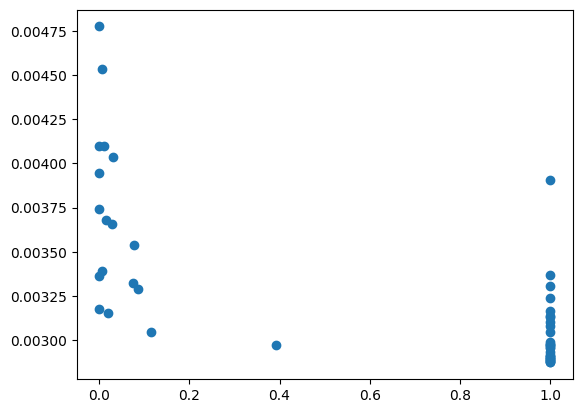

In [121]:
plt.scatter(results_df['iou_list'],results_df['uncertainty_list'])

In [9]:
def create_args(user='anissa', experiment='U192_valfix2', date=None, description='Trustworthy medical image segmentation by coco, training on trai_imgsn.txt!',
                mode='train', dataset='autopet', crop_H=192, crop_W=192, crop_D=192, num_classes=2,
                input_modality='petct', folder='folder0', input_C=2, input_H=192, input_W=192, input_D=192,
                output_D=192, lr=0.0002, weight_decay=1e-5, submission='./results', seed=1000, no_cuda=False,
                batch_size=2, start_epoch=0, end_epochs=10, lambda_epochs = 50,save_freq=5, resume='', load=True, model_name='U',
                en_time=10, OOD_Condition='normal', OOD_Level=1, use_TTA=False, snapshot=True, save_format='nii',
                test_date='2023-01-01', test_epoch=199, n_skip=3, vit_name='R50-ViT-B_16', vit_patches_size=16,train_file = 'pos_train_imgs.txt',val_file = 'pos_val_imgs.txt',test_file = 'pos_test_imgs.txt',Uncertainty_Loss=False,save_dir='./results'):
    local_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    date = local_time.split(' ')[0] if date is None else date

    args = argparse.Namespace(user=user, experiment=experiment, date=date, description=description,
                              mode=mode, dataset=dataset, crop_H=crop_H, crop_W=crop_W, crop_D=crop_D,
                              num_classes=num_classes, input_modality=input_modality, folder=folder,
                              input_C=input_C, input_H=input_H, input_W=input_W, input_D=input_D,
                              output_D=output_D, lr=lr, weight_decay=weight_decay, submission=submission,
                              seed=seed, no_cuda=no_cuda, batch_size=batch_size, start_epoch=start_epoch,
                              end_epochs=end_epochs, save_freq=save_freq, resume=resume, load=load,
                              model_name=model_name, en_time=en_time, OOD_Condition=OOD_Condition,
                              OOD_Level=OOD_Level, use_TTA=use_TTA, snapshot=snapshot, save_format=save_format,
                              test_date=test_date, test_epoch=test_epoch, n_skip=n_skip, vit_name=vit_name,
                              vit_patches_size=vit_patches_size,train_file=train_file,val_file=val_file,test_file=test_file,lambda_epochs=lambda_epochs,Uncertainty_Loss=Uncertainty_Loss,save_dir=save_dir)

    return args

In [10]:
    args = create_args()

    #args = getArgs()
    print(args.dataset)
    if args.dataset == 'autopet':
        args.batch_size = 2
        args.num_classes = 2
        args.out_size = (128, 128,128)
        #args.out_size = (400, 400,400) # tried this
    elif args.dataset == 'autopet2':
        args.batch_size = 2
        args.num_classes = 2
        args.out_size = (192, 192,192)
    elif args.dataset == 'BraTS':
        args.batch_size = 2
        args.num_classes = 4
        args.out_size = (240, 240,160)
        input_tensor = torch.randn(1, 4, args.out_size[0], args.out_size[1], args.out_size[2]).cuda()
    else:
        print('There is no this dataset')
        raise NameError
    
    train_loader, valid_loader, test_loader = getDataset(args)
    model = TMSU(args)
    # calculate model's Params & Flops
    total = sum([param.nelement() for param in model.parameters()])
    print("Number of model's Params: %.2fM" % (total / 1e6))

    optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)
    model.cuda()

    log_dir = os.path.join(os.path.abspath((os.getcwd())), 'log', args.experiment + args.date)
    log_file = log_dir + '.txt'
    log_args(log_file)
    epoch_loss = 0
    best_dice = 0
    loss_list = []
    dice_list = []
    OOD_Condition = ['noise','blur','mask']

    # resume = ''
    # if os.path.isfile(resume):
    #     logging.info('loading checkpoint {}'.format(resume))
    #     checkpoint = torch.load(resume, map_location=lambda storage, loc: storage)
    #     model.load_state_dict(checkpoint['state_dict'])
    #     args.start_epoch = checkpoint['epoch']
    #     logging.info('Successfully loading checkpoint {} and training from epoch: {}'
    #                  .format(resume, args.start_epoch))
    # else:
    #     logging.info('re-training!!!')
    #writer = SummaryWriter()

autopet
Samples for train = 358
Samples for valid = 47
Samples for test = 46
Number of model's Params: 4.76M


In [8]:
    # redo inference for 192 model
    import nibabel as nib
    model_name ='U_pos_128_valfix2_U_autopet2_folder_epoch_108.pth'
    #model_name = 'U_autopet_folder0_epoch_199.pth'
    Net_name = args.model_name
    snapshot = args.snapshot  # False
    logging.info('===========>Test begining!===========')
    logging.info('--------------------------------------This is all argsurations----------------------------------')
    for arg in vars(args):
        logging.info('{}={}'.format(arg, getattr(args, arg)))
    logging.info('----------------------------------------This is a halving line----------------------------------')
    logging.info('{}'.format(args.description))
    
    if args.Uncertainty_Loss:
        savepath = args.submission + '/'+ str(Net_name) + 'eviloss'  + '/' + str(args.dataset) +'/' + str(args.OOD_Condition) +'/'+ str(args. OOD_Level)
    else:
        savepath = args.submission + '/' + str(Net_name)+ 'evi' + '/' + str(args.dataset) +'/' + str(args.OOD_Condition) + '/' + str(args.OOD_Level)
    dice_total = 0
    dice_total_WT = 0
    dice_total_TC = 0
    dice_total_ET = 0
    hd_total = 0
    hd95_total = 0
    assd_total = 0
    hd_total_WT = 0
    hd_total_TC = 0
    hd_total_ET = 0
    assd_total_WT = 0
    assd_total_TC = 0
    assd_total_ET = 0
    noise_dice_total = 0
    noise_dice_total_WT = 0
    noise_dice_total_TC = 0
    noise_dice_total_ET = 0
    iou_total = 0
    iou_total_WT = 0
    iou_total_TC = 0
    iou_total_ET = 0
    noise_iou_total = 0
    noise_iou_total_WT = 0
    noise_iou_total_TC = 0
    noise_iou_total_ET = 0
    noise_hd_total = 0
    noise_assd_total = 0
    noise_hd_total_WT = 0
    noise_hd_total_TC = 0
    noise_hd_total_ET = 0
    noise_assd_total_WT = 0
    noise_assd_total_TC = 0
    noise_assd_total_ET = 0
    runtimes = []
    certainty_total = 0
    noise_certainty_total = 0
    mne_total = 0
    noise_mne_total = 0
    ece_total = 0
    noise_ece_total = 0
    ueo_total = 0
    noise_ueo_total = 0
    step = 0

    dt_size = len(test_loader.dataset)
    if args.Uncertainty_Loss:
        #load_file = os.path.join(os.path.abspath(os.path.dirname(__file__)),
                                 #args.save_dir,
                                 #args.experiment + '_' + args.model_name + '_' + args.dataset +'_'+ args.folder + '_DUloss' + '_epoch_{}.pth'.format(args.test_epoch))
        load_file = os.path.join('/gpfs3/well/papiez/users/hri611/python/UMIS/results/',model_name) # changed anissa

    else:
        #load_file = os.path.join(os.path.abspath(os.path.dirname(__file__)),
                                 #args.save_dir,
                                 #args.experiment + '_' + args.model_name + '_' + args.dataset +'_'+ args.folder + '_epoch_{}.pth'.format(args.test_epoch))
        load_file = os.path.join('/gpfs3/well/papiez/users/hri611/python/UMIS/results/',model_name) # changed anissa


    if os.path.exists(load_file):
        checkpoint = torch.load(load_file)
        model.load_state_dict(checkpoint['state_dict'])
        args.start_epoch = checkpoint['epoch']
        print('Successfully load checkpoint {}'.format(
            os.path.join(args.save_dir + '/' + args.model_name +'_'+args.dataset+ '_epoch_' + str(args.test_epoch))))
    else:
        print('There is no resume file to load!')
    names = test_loader.dataset.image_list

    model.eval()

    dice_list = []
    iou_list = []
    uncertainty_list =[]
    num_classes_list=[]
    hd_list = []
    ueo_list = []
    name_list =[]

    for i, data in enumerate(test_loader):
        msg = 'Subject {}/{}, '.format(i + 1, len(test_loader))

        step += 1
        #input, noised_input, target = data  # input ground truth
        input, target = data

        if args.dataset == 'BraTS':
            num_classes = 4
        elif args.dataset == 'autopet' or args.dataset == 'autopet2':
            num_classes = 2
        else:
            num_classes = 2
        
        x = input.cuda()
        #noised_x = noised_input.cuda()
        target = target.cuda()
        torch.cuda.synchronize()  # add the code synchronize() to correctly count the runtime.
        start_time = time.time()
        with torch.no_grad():
            args.mode = 'test'
            if args.dataset =='BraTS':
                evidences = model(x, target[:, :, :, :155], 0, args.mode, args.dataset)
                noised_evidences = model(noised_x, target[:, :, :, :155], 0, args.mode, args.dataset)
            else:
                evidences = model(x, target, 0, args.mode, args.dataset)
                #noised_evidences = model(noised_x, target, 0, args.mode, args.dataset)
            torch.cuda.synchronize()
            elapsed_time = time.time() - start_time
            logging.info('Single sample test time consumption {:.2f} seconds!'.format(elapsed_time))
            runtimes.append(elapsed_time)
            alpha = evidences + 1
            uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)

            S = torch.sum(alpha, dim=1, keepdim=True)
            prob = alpha / S
            mne = Uentropy_our(prob, num_classes)
            # min_mne = torch.min(mne)
            # max_mne = torch.max(mne)

            _, predicted = torch.max(alpha / S, 1)
            output = torch.squeeze(predicted).cpu().detach().numpy()
            # n of unique classes
            num_class = target.max()

            # for noise_x
            # noised_alpha = noised_evidences + 1
            # noised_uncertainty = num_classes / torch.sum(noised_alpha, dim=1, keepdim=True)

            # _, noised_predicted = torch.max(noised_evidences.data, 1)
            # noised_prob = noised_alpha / torch.sum(noised_alpha, dim=1, keepdim=True)
            # noised_mne = Uentropy_our(noised_prob, num_classes)
            # noised_output = torch.squeeze(noised_predicted).cpu().detach().numpy()

            if args.dataset=='autopet' or args.dataset=='autopet2':
                ece = cal_ece_our(torch.squeeze(predicted), torch.squeeze(target.cpu()))
                H, W, T = args.crop_H, args.crop_W, args.crop_D # not sure about this anissa
                
                Otarget = torch.squeeze(target).cpu().numpy()
                target = torch.squeeze(target).cpu().numpy()  # .cpu().numpy(dtype='float32')
                hd_res = softmax_output_hd(output, target)
                assd_res = softmax_assd_score(output, target)
                iou_res = softmax_mIOU_score(output, target)
                dice_res = softmax_output_dice(output, target)
                dice_total_WT += dice_res[0]
                iou_total_WT += iou_res[0]
                hd_total_WT += hd_res[0]
                assd_total_WT += assd_res[0]

                mean_uncertainty = torch.mean(uncertainty)
                
                # mne & ece
                mne_total += torch.mean(mne)  # mix _uncertainty mean_uncertainty mean_uncertainty_succ
                
                # ece
                ece_total += ece
                # U ece ueo
                certainty_total += mean_uncertainty  # mix _uncertainty mean_uncertainty mean_uncertainty_succ
                pc = output

                # ueo
                thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
                to_evaluate = dict()
                to_evaluate['target'] = target
                u = torch.squeeze(uncertainty)
                U = u.cpu().detach().numpy()
                to_evaluate['prediction'] = pc
                to_evaluate['uncertainty'] = U
                UEO = cal_ueo(to_evaluate, thresholds)
                ueo_total += UEO
                print('current_UEO:{}; current_num:{}'.format(UEO, i))

                # confidence map
                conf = 1-uncertainty
                confe = torch.exp(-uncertainty)
                mean_conf = torch.mean(conf)
                mean_confe = torch.mean(confe)
                conf_output = torch.squeeze(conf).cpu().detach().numpy()
                confe_output = torch.squeeze(confe).cpu().detach().numpy()
                
                print('current_U:{};current_num:{}'.format(mean_uncertainty, i))
                print('current_conf:{};current_num:{}'.format(mean_conf, i))
                print('current_confe:{};current_num:{}'.format(mean_confe, i))
                # logging.info('current_U:{};current_num:{}'.format(mean_uncertainty,i))
                # logging.info('current_conf:{};current_num:{}'.format(mean_conf,i))
                # logging.info('current_confe:{};current_num:{}'.format(mean_confe, i))
                
                # uncertainty np
                Otarget = target
                Oinput = torch.squeeze(x,0).cpu().detach().numpy()
                U_output = torch.squeeze(uncertainty).cpu().detach().numpy()
                # U_output = torch.squeeze(mne).cpu().detach().numpy()
                
                name = str(i)
                if names:
                    name = names[i]
                    msg += '{:>20}, '.format(name)

                # save each image

                output_dir = 'test_output_' + str(model_name)
                sub_dir = name  # Assuming 'name' is the directory you want to create

                # Check if the directories exist before creating them
                if not os.path.exists(output_dir):
                    os.mkdir(output_dir)
                if not os.path.exists(os.path.join(output_dir,sub_dir)):
                    os.mkdir(os.path.join(output_dir,sub_dir))
                
                # save inputs
                ct = x[0,0,:,:,:].cpu().numpy()
                pet = x[0,1,:,:,:].cpu().numpy()
                ct_nii = nib.Nifti1Image(ct, affine=np.eye(4))  # You might need to adjust the 'affine' matrix
                pet_nii = nib.Nifti1Image(pet, affine=np.eye(4))  # You might need to adjust the 'affine' matrix
                # Save the NIfTI image to a .nii.gz file
                nib.save(ct_nii, os.path.join(output_dir,sub_dir, 'ct_input.nii.gz'))
                nib.save(pet_nii, os.path.join(output_dir,sub_dir, 'pet_input.nii.gz'))
                
                target = target.astype(np.float32)
                target_nii = nib.Nifti1Image(target, affine=np.eye(4))  # You may need to adjust the affine matrix
                # Save the NIfTI image to a file
                nib.save(target_nii, os.path.join(output_dir,sub_dir, 'target.nii.gz'))
                
                output = output.astype(np.float32)
                output_nii = nib.Nifti1Image(output, affine=np.eye(4))  # You may need to adjust the affine matrix
                # Save the NIfTI image to a file
                nib.save(output_nii, os.path.join(output_dir,sub_dir, 'output.nii.gz'))

                uncertainty = uncertainty[0,0,:,:,:].cpu().numpy()
                uncertainty_nii = nib.Nifti1Image(uncertainty, affine=np.eye(4))  # You might need to adjust the 'affine' matrix
                # Save the NIfTI image to a .nii.gz file
                nib.save(uncertainty_nii, os.path.join(output_dir,sub_dir, 'uncertainty.nii.gz'))
                
                dice_list.append(dice_res[0])
                iou_list.append(iou_res[0])
                uncertainty_list.append(mean_uncertainty.cpu())
                num_classes_list.append(num_class.cpu()) # 0 if only background, 1 if both
                hd_list.append(hd_res[0])
                ueo_list.append(UEO)
                name_list.append(name)

# save results as df
results_df = pd.DataFrame()
results_df['image']=name_list
results_df['dice_list']=dice_list
results_df['iou_list']=iou_list
results_df['uncertainty_list']=[float(tensor) for tensor in uncertainty_list]
results_df['num_classes_list']=[float(tensor) for tensor in num_classes_list]
results_df['hd_list']=hd_list
results_df['ueo_list']=ueo_list

df_name = str(model_name)+'_test_results'
results_df.to_csv(df_name)

2023-09-21 11:56:57 ===> ===========>Test begining!===========
2023-09-21 11:56:57 ===> --------------------------------------This is all argsurations----------------------------------
2023-09-21 11:56:57 ===> user=anissa
2023-09-21 11:56:57 ===> experiment=U192_valfix2
2023-09-21 11:56:57 ===> date=2023-09-21
2023-09-21 11:56:57 ===> description=Trustworthy medical image segmentation by coco, training on trai_imgsn.txt!
2023-09-21 11:56:57 ===> mode=train
2023-09-21 11:56:57 ===> dataset=autopet
2023-09-21 11:56:57 ===> crop_H=192
2023-09-21 11:56:57 ===> crop_W=192
2023-09-21 11:56:57 ===> crop_D=192
2023-09-21 11:56:57 ===> num_classes=2
2023-09-21 11:56:57 ===> input_modality=petct
2023-09-21 11:56:57 ===> folder=folder0
2023-09-21 11:56:57 ===> input_C=2
2023-09-21 11:56:57 ===> input_H=192
2023-09-21 11:56:57 ===> input_W=192
2023-09-21 11:56:57 ===> input_D=192
2023-09-21 11:56:57 ===> output_D=192
2023-09-21 11:56:57 ===> lr=0.0002
2023-09-21 11:56:57 ===> weight_decay=1e-05
20

There is no resume file to load!


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 163 but got size 164 for tensor number 1 in the list.

In [10]:
## TRY SLIDING WINDOW INFERENCE

In [11]:
patch_size = (128, 128, 128)
overlap = (16, 16, 16)  # Adjust the overlap as needed

# Function to split a 3D image into overlapping patches
def split_image_into_patches(image):
    patches = []
    _,_, depth, height, width = image.shape
    z_stride, y_stride, x_stride = patch_size[0] - overlap[0], patch_size[1] - overlap[1], patch_size[2] - overlap[2]

    for z in range(0, depth, z_stride):
        for y in range(0, height, y_stride):
            for x in range(0, width, x_stride):

                patch = image[:, :, z:z+patch_size[0], y:y+patch_size[1], x:x+patch_size[2]]
                z_pad,x_pad,y_pad = 0,0,0

                if patch.shape[2] < 128:
                    z_pad = 128 - patch.shape[2]
                if patch.shape[3] <128:
                    y_pad = 128 - patch.shape[3]
                if patch.shape[4] < 128:
                    x_pad = 128 - patch.shape[4]
    
                # Extract the patch and zero pad it
                patch = np.pad(patch, ((0, 0), (0, 0), (0, z_pad), (0, y_pad), (0, x_pad)), mode='constant', constant_values=0)
                
                patch = torch.tensor(patch)
                patches.append(patch)

    return patches

def reconstruct_image_from_patches(patches, original_shape, patch_size, overlap):
    '''
    patches = list of 3d numpy arrays
    returns: torch.tensor
    '''
    depth, height, width = original_shape
    reconstructed_image = torch.zeros(original_shape)

    # Initialize counts and zero-padding
    patch_count = torch.zeros((depth, height, width), dtype=torch.float32)
    z_stride, y_stride, x_stride = patch_size[0] - overlap[0], patch_size[1] - overlap[1], patch_size[2] - overlap[2]

    for z in range(0, depth, z_stride):
        for y in range(0, height, y_stride):
            for x in range(0, width, x_stride):
                # Get the patch
                patch = patches.pop(0)  # Assuming patches is a list

                # Update counts for overlapping regions
                z_end = min(z + patch_size[0], depth)
                y_end = min(y + patch_size[1], height)
                x_end = min(x + patch_size[2], width)
                patch_count[z:z_end, y:y_end, x:x_end] += 1

                # Accumulate the patch
                reconstructed_image[z:z_end, y:y_end, x:x_end] += patch[:z_end - z, :y_end - y, :x_end - x]

    # Average overlapping regions by dividing by patch_count
    reconstructed_image /= patch_count

    return reconstructed_image

In [50]:
tensor_4d = torch.randn(1,2, 384, 400, 400)
patches = split_image_into_patches(tensor_4d)

In [27]:
len(patches)

64

In [29]:
patches[0].shape

torch.Size([1, 2, 128, 128, 128])

In [54]:
    # redo inference for 192 model
    import nibabel as nib
    model_name ='U_pos_128_valfix2_U_autopet2_folder_epoch_108.pth'
    #model_name = 'U_autopet_folder0_epoch_199.pth'
    Net_name = args.model_name
    snapshot = args.snapshot  # False
    logging.info('===========>Test begining!===========')
    logging.info('--------------------------------------This is all argsurations----------------------------------')
    for arg in vars(args):
        logging.info('{}={}'.format(arg, getattr(args, arg)))
    logging.info('----------------------------------------This is a halving line----------------------------------')
    logging.info('{}'.format(args.description))
    
    if args.Uncertainty_Loss:
        savepath = args.submission + '/'+ str(Net_name) + 'eviloss'  + '/' + str(args.dataset) +'/' + str(args.OOD_Condition) +'/'+ str(args. OOD_Level)
    else:
        savepath = args.submission + '/' + str(Net_name)+ 'evi' + '/' + str(args.dataset) +'/' + str(args.OOD_Condition) + '/' + str(args.OOD_Level)
    dice_total = 0
    dice_total_WT = 0
    dice_total_TC = 0
    dice_total_ET = 0
    hd_total = 0
    hd95_total = 0
    assd_total = 0
    hd_total_WT = 0
    hd_total_TC = 0
    hd_total_ET = 0
    assd_total_WT = 0
    assd_total_TC = 0
    assd_total_ET = 0
    noise_dice_total = 0
    noise_dice_total_WT = 0
    noise_dice_total_TC = 0
    noise_dice_total_ET = 0
    iou_total = 0
    iou_total_WT = 0
    iou_total_TC = 0
    iou_total_ET = 0
    noise_iou_total = 0
    noise_iou_total_WT = 0
    noise_iou_total_TC = 0
    noise_iou_total_ET = 0
    noise_hd_total = 0
    noise_assd_total = 0
    noise_hd_total_WT = 0
    noise_hd_total_TC = 0
    noise_hd_total_ET = 0
    noise_assd_total_WT = 0
    noise_assd_total_TC = 0
    noise_assd_total_ET = 0
    runtimes = []
    certainty_total = 0
    noise_certainty_total = 0
    mne_total = 0
    noise_mne_total = 0
    ece_total = 0
    noise_ece_total = 0
    ueo_total = 0
    noise_ueo_total = 0
    step = 0

    dt_size = len(test_loader.dataset)
    if args.Uncertainty_Loss:
        #load_file = os.path.join(os.path.abspath(os.path.dirname(__file__)),
                                 #args.save_dir,
                                 #args.experiment + '_' + args.model_name + '_' + args.dataset +'_'+ args.folder + '_DUloss' + '_epoch_{}.pth'.format(args.test_epoch))
        load_file = os.path.join('/gpfs3/well/papiez/users/hri611/python/UMIS/results/',model_name) # changed anissa

    else:
        #load_file = os.path.join(os.path.abspath(os.path.dirname(__file__)),
                                 #args.save_dir,
                                 #args.experiment + '_' + args.model_name + '_' + args.dataset +'_'+ args.folder + '_epoch_{}.pth'.format(args.test_epoch))
        load_file = os.path.join('/gpfs3/well/papiez/users/hri611/python/UMIS/results/',model_name) # changed anissa


    if os.path.exists(load_file):
        checkpoint = torch.load(load_file)
        model.load_state_dict(checkpoint['state_dict'])
        args.start_epoch = checkpoint['epoch']
        print('Successfully load checkpoint {}'.format(
            os.path.join(args.save_dir + '/' + args.model_name +'_'+args.dataset+ '_epoch_' + str(args.test_epoch))))
    else:
        print('There is no resume file to load!')
    names = test_loader.dataset.image_list

    model.eval()

    big_dice_list = []
    big_iou_list = []
    big_uncertainty_list =[]
    big_num_classes_list=[]
    big_hd_list = []
    big_ueo_list = []
    big_name_list =[]

    for i, data in enumerate(test_loader):
        msg = 'Subject {}/{}, '.format(i + 1, len(test_loader))
        if args.dataset == 'BraTS':
            num_classes = 4
        elif args.dataset == 'autopet' or args.dataset == 'autopet2':
            num_classes = 2
        else:
            num_classes = 2

        dice_list = []
        iou_list = []
        uncertainty_list =[]
        num_classes_list=[]
        hd_list = []
        ueo_list = []
        name_list =[]
        uncertainty_imgs= []
        output_list = []

        ori_input, ori_target = data
        # input and target are 5d tensors 

        input_patches = split_image_into_patches(ori_input)
        target_patches = split_image_into_patches(ori_target)
        
        for j, patch in enumerate(input_patches):

            input = patch
            target = target_patches[j]
            print(input.shape)
            print(target.shape)
            
            step += 1
            #input, noised_input, target = data  # input ground truth
            
            x = input.cuda()
            #noised_x = noised_input.cuda()
            target = target.cuda()
            torch.cuda.synchronize()  # add the code synchronize() to correctly count the runtime.
            start_time = time.time()
            with torch.no_grad():
                args.mode = 'test'
                if args.dataset =='BraTS':
                    evidences = model(x, target[:, :, :, :155], 0, args.mode, args.dataset)
                else:
                    evidences = model(x, target, 0, args.mode, args.dataset)
                    #noised_evidences = model(noised_x, target, 0, args.mode, args.dataset)
                torch.cuda.synchronize()
                elapsed_time = time.time() - start_time
                logging.info('Single sample test time consumption {:.2f} seconds!'.format(elapsed_time))
                runtimes.append(elapsed_time)
                alpha = evidences + 1
                uncertainty = num_classes / torch.sum(alpha, dim=1, keepdim=True)
    
                S = torch.sum(alpha, dim=1, keepdim=True)
                prob = alpha / S
                mne = Uentropy_our(prob, num_classes)
    
                _, predicted = torch.max(alpha / S, 1)
                output = torch.squeeze(predicted).cpu().detach().numpy()
                # n of unique classes
                num_class = target.max()
    
                if args.dataset=='autopet' or args.dataset=='autopet2':
                    #ece = cal_ece_our(torch.squeeze(predicted), torch.squeeze(target.cpu()))
                    H, W, T = args.crop_H, args.crop_W, args.crop_D # not sure about this anissa
                    
                    Otarget = torch.squeeze(target).cpu().numpy()
                    target = torch.squeeze(target).cpu().numpy()  # .cpu().numpy(dtype='float32')

                    hd_res = softmax_output_hd(output, target)
                    assd_res = softmax_assd_score(output, target)
                    iou_res = softmax_mIOU_score(output, target)
                    dice_res = softmax_output_dice(output, target)
                    dice_total_WT += dice_res[0]
                    iou_total_WT += iou_res[0]
                    hd_total_WT += hd_res[0]
                    assd_total_WT += assd_res[0]
    
                    mean_uncertainty = torch.mean(uncertainty)
                    
                    # mne & ece
                    #mne_total += torch.mean(mne)  # mix _uncertainty mean_uncertainty mean_uncertainty_succ
                    
                    # ece
                    #ece_total += ece
                    # U ece ueo
                    #certainty_total += mean_uncertainty  # mix _uncertainty mean_uncertainty mean_uncertainty_succ
                    pc = output
    
                    # ueo
                    thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
                    to_evaluate = dict()
                    to_evaluate['target'] = target
                    u = torch.squeeze(uncertainty)
                    U = u.cpu().detach().numpy()
                    to_evaluate['prediction'] = pc
                    to_evaluate['uncertainty'] = U
                    UEO = cal_ueo(to_evaluate, thresholds)
                    ueo_total += UEO
                    print('current_UEO:{}; current_num:{}'.format(UEO, i))
    
                    # confidence map
                    conf = 1-uncertainty
                    confe = torch.exp(-uncertainty)
                    mean_conf = torch.mean(conf)
                    mean_confe = torch.mean(confe)
                    conf_output = torch.squeeze(conf).cpu().detach().numpy()
                    confe_output = torch.squeeze(confe).cpu().detach().numpy()
                    
                    print('current_U:{};current_num:{}'.format(mean_uncertainty, i))
                    print('current_conf:{};current_num:{}'.format(mean_conf, i))
                    print('current_confe:{};current_num:{}'.format(mean_confe, i))
                    
                    # uncertainty np
                    Otarget = target
                    Oinput = torch.squeeze(x,0).cpu().detach().numpy()
                    U_output = torch.squeeze(uncertainty).cpu().detach().numpy()
                    # U_output = torch.squeeze(mne).cpu().detach().numpy()
                    
                    name = str(i)
                    if names:
                        name = names[i]
                        msg += '{:>20}, '.format(name)
                    
                    # outputs you want for each patch
                    ct = x[0,0,:,:,:].cpu().numpy()
                    pet = x[0,1,:,:,:].cpu().numpy()
                    target = target.astype(np.float32)
                    #output = output.astype(np.float32)
                    output = torch.tensor(output)
                    uncertainty = uncertainty[0,0,:,:,:].cpu().numpy()
                    predicted = predicted[0,:,:,:].cpu().numpy()


                    uncertainty_imgs.append(uncertainty)
                    output_list.append(predicted)
    
                    dice_list.append(dice_res[0])
                    iou_list.append(iou_res[0])
                    uncertainty_list.append(mean_uncertainty.cpu())
                    num_classes_list.append(num_class.cpu()) # 0 if only background, 1 if both
                    hd_list.append(hd_res[0])
                    ueo_list.append(UEO)
                    name_list.append(name)

        # PATCH TOGETHER PREDICTIONS
        ct = ori_input[0,0,:,:,:].cpu().numpy()
        pet = ori_input[0,1,:,:,:].cpu().numpy()
        target = ori_target.cpu().numpy().astype(np.float32) # think it's a tensor

        image_output = reconstruct_image_from_patches(output_list,ori_target.shape[2:], patch_size, overlap)
        output = image_output.cpu().numpy().astype(np.float32)
        # this is a torch.tensor

        image_uncertainty = reconstruct_image_from_patches(uncertainty_imgs,ori_target.shape[2:], patch_size, overlap)
        uncertainty = image_uncertainty.cpu().numpy().astype(np.float32)
        # think uncertainty list is a 3d numpy array
        
        print(image_output)
        print(uncertainty)

        big_dice_list.append(dice_list)
        big_iou_list.append(iou_list)
        big_uncertainty_list.append(uncertainty_list)
        big_num_classes_list.append(num_classes_list)
        big_hd_list.append(hd_list)
        big_ueo_list.append(ueo_list)
        big_name_list.append(name_list)
           
        # outputs you want for each image
        output_dir = 'test_output_swin' + str(model_name)
        sub_dir = name  # Assuming 'name' is the directory you want to create
    
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
        if not os.path.exists(os.path.join(output_dir,sub_dir)):
            os.mkdir(os.path.join(output_dir,sub_dir))

        ct_nii = nib.Nifti1Image(ct, affine=np.eye(4))  # You might need to adjust the 'affine' matrix
        pet_nii = nib.Nifti1Image(pet, affine=np.eye(4))  # You might need to adjust the 'affine' matrix
        # Save the NIfTI image to a .nii.gz file
        nib.save(ct_nii, os.path.join(output_dir,sub_dir, 'ct_input.nii.gz'))
        nib.save(pet_nii, os.path.join(output_dir,sub_dir, 'pet_input.nii.gz'))
                
        target_nii = nib.Nifti1Image(target, affine=np.eye(4))  # You may need to adjust the affine matrix
        # Save the NIfTI image to a file
        nib.save(target_nii, os.path.join(output_dir,sub_dir, 'target.nii.gz'))
                
        output_nii = nib.Nifti1Image(output, affine=np.eye(4))  # You may need to adjust the affine matrix
        # Save the NIfTI image to a file
        nib.save(output_nii, os.path.join(output_dir,sub_dir, 'output.nii.gz'))

        uncertainty_nii = nib.Nifti1Image(uncertainty, affine=np.eye(4))  # You might need to adjust the 'affine' matrix
        # Save the NIfTI image to a .nii.gz file
        nib.save(uncertainty_nii, os.path.join(output_dir,sub_dir, 'uncertainty.nii.gz'))
                

# save results as df

big_dice_list.to_csv(str(model_name) + '_dice_list.csv')
big_iou_list.to_csv(str(model_name) + '_iou_list.csv')
big_uncertainty_list.to_csv(str(model_name) + '_uncertainty_list.csv')
big_num_classes_list.to_csv(str(model_name) + '_numclass_list.csv')
big_hd_list.to_csv(str(model_name) + '_hd_list.csv')
big_ueo_list.to_csv(str(model_name) + '_ueo_list.csv')
big_name_list.to_csv(str(model_name) + '_name_list.csv')

2023-09-21 15:40:42 ===> ===========>Test begining!===========
2023-09-21 15:40:42 ===> --------------------------------------This is all argsurations----------------------------------
2023-09-21 15:40:42 ===> user=anissa
2023-09-21 15:40:42 ===> experiment=U192_valfix2
2023-09-21 15:40:42 ===> date=2023-09-21
2023-09-21 15:40:42 ===> description=Trustworthy medical image segmentation by coco, training on trai_imgsn.txt!
2023-09-21 15:40:42 ===> mode=test
2023-09-21 15:40:42 ===> dataset=autopet
2023-09-21 15:40:42 ===> crop_H=192
2023-09-21 15:40:42 ===> crop_W=192
2023-09-21 15:40:42 ===> crop_D=192
2023-09-21 15:40:42 ===> num_classes=2
2023-09-21 15:40:42 ===> input_modality=petct
2023-09-21 15:40:42 ===> folder=folder0
2023-09-21 15:40:42 ===> input_C=2
2023-09-21 15:40:42 ===> input_H=192
2023-09-21 15:40:42 ===> input_W=192
2023-09-21 15:40:42 ===> input_D=192
2023-09-21 15:40:42 ===> output_D=192
2023-09-21 15:40:42 ===> lr=0.0002
2023-09-21 15:40:42 ===> weight_decay=1e-05
202

There is no resume file to load!


2023-09-21 15:40:44 ===> Single sample test time consumption 0.03 seconds!


torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:40:46 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.47067704796791077;current_num:0
current_conf:0.5293229818344116;current_num:0
current_confe:0.6246172189712524;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:40:48 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.4765195846557617;current_num:0
current_conf:0.5234804153442383;current_num:0
current_confe:0.6211553812026978;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:40:49 ===> Single sample test time consumption 0.04 seconds!


current_UEO:0.0; current_num:0
current_U:0.4727958142757416;current_num:0
current_conf:0.527204155921936;current_num:0
current_confe:0.6233594417572021;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:40:51 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.5264914631843567;current_num:0
current_conf:0.4735085070133209;current_num:0
current_confe:0.5917640924453735;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:40:52 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.473274290561676;current_num:0
current_conf:0.5267256498336792;current_num:0
current_confe:0.6230998039245605;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:40:54 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.5417388081550598;current_num:0
current_conf:0.4582611918449402;current_num:0
current_confe:0.582710862159729;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:40:55 ===> Single sample test time consumption 0.04 seconds!


current_UEO:0.0; current_num:0
current_U:0.5177351236343384;current_num:0
current_conf:0.4822648763656616;current_num:0
current_confe:0.5969392657279968;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:40:56 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.5265015363693237;current_num:0
current_conf:0.47349846363067627;current_num:0
current_confe:0.5917579531669617;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:40:57 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.4706662893295288;current_num:0
current_conf:0.5293337106704712;current_num:0
current_confe:0.6246238946914673;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:40:59 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.4729221761226654;current_num:0
current_conf:0.5270777940750122;current_num:0
current_confe:0.6232949495315552;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:00 ===> Single sample test time consumption 0.04 seconds!


current_UEO:0.0; current_num:0
current_U:0.4717159867286682;current_num:0
current_conf:0.5282840728759766;current_num:0
current_confe:0.6240040063858032;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:01 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.5264935493469238;current_num:0
current_conf:0.4735064208507538;current_num:0
current_confe:0.5917627811431885;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:03 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.5266517400741577;current_num:0
current_conf:0.4733482599258423;current_num:0
current_confe:0.5916659235954285;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:04 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.5266530513763428;current_num:0
current_conf:0.4733469784259796;current_num:0
current_confe:0.5916651487350464;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:06 ===> Single sample test time consumption 0.04 seconds!


current_UEO:0.0; current_num:0
current_U:0.5266522169113159;current_num:0
current_conf:0.4733477830886841;current_num:0
current_confe:0.5916656255722046;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:07 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.552714467048645;current_num:0
current_conf:0.44728559255599976;current_num:0
current_confe:0.5762313008308411;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:08 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.4706827998161316;current_num:0
current_conf:0.5293172597885132;current_num:0
current_confe:0.6246137022972107;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:09 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.4768846333026886;current_num:0
current_conf:0.523115336894989;current_num:0
current_confe:0.6209428310394287;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:11 ===> Single sample test time consumption 0.04 seconds!


current_UEO:0.0; current_num:0
current_U:0.47315043210983276;current_num:0
current_conf:0.5268495082855225;current_num:0
current_confe:0.6231511831283569;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:12 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.526491641998291;current_num:0
current_conf:0.473508358001709;current_num:0
current_confe:0.5917640328407288;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:13 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.47231632471084595;current_num:0
current_conf:0.527683675289154;current_num:0
current_confe:0.6236557960510254;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:16 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.00017546067964312824; current_num:0
current_U:0.5516776442527771;current_num:0
current_conf:0.4483223557472229;current_num:0
current_confe:0.5768617391586304;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:20 ===> Single sample test time consumption 0.04 seconds!


current_UEO:0.0002584123469610088; current_num:0
current_U:0.5212575197219849;current_num:0
current_conf:0.47874248027801514;current_num:0
current_confe:0.5947655439376831;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:21 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.5265003442764282;current_num:0
current_conf:0.47349968552589417;current_num:0
current_confe:0.5917586088180542;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:22 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.4706727862358093;current_num:0
current_conf:0.5293271541595459;current_num:0
current_confe:0.6246198415756226;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:23 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.48378223180770874;current_num:0
current_conf:0.5162177681922913;current_num:0
current_confe:0.6169120073318481;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:25 ===> Single sample test time consumption 0.04 seconds!


current_UEO:0.0; current_num:0
current_U:0.47864216566085815;current_num:0
current_conf:0.5213578939437866;current_num:0
current_confe:0.6199419498443604;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:26 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.5264978408813477;current_num:0
current_conf:0.47350215911865234;current_num:0
current_confe:0.5917602777481079;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:27 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.5266517400741577;current_num:0
current_conf:0.4733482599258423;current_num:0
current_confe:0.5916658639907837;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:29 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.5266540050506592;current_num:0
current_conf:0.4733460247516632;current_num:0
current_confe:0.5916645526885986;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:30 ===> Single sample test time consumption 0.04 seconds!


current_UEO:0.0; current_num:0
current_U:0.526652455329895;current_num:0
current_conf:0.473347544670105;current_num:0
current_confe:0.591665506362915;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:31 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.552714467048645;current_num:0
current_conf:0.44728559255599976;current_num:0
current_confe:0.5762313008308411;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:32 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.4941055178642273;current_num:0
current_conf:0.5058945417404175;current_num:0
current_confe:0.6108708381652832;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:34 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.49601632356643677;current_num:0
current_conf:0.503983736038208;current_num:0
current_confe:0.609724760055542;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:35 ===> Single sample test time consumption 0.04 seconds!


current_UEO:0.0; current_num:0
current_U:0.4945877194404602;current_num:0
current_conf:0.5054122805595398;current_num:0
current_confe:0.6105791330337524;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:36 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.536994218826294;current_num:0
current_conf:0.46300578117370605;current_num:0
current_confe:0.5855399966239929;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:38 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.5003430843353271;current_num:0
current_conf:0.49965691566467285;current_num:0
current_confe:0.6071928143501282;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:41 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0003013169744915157; current_num:0
current_U:0.5346918106079102;current_num:0
current_conf:0.46530818939208984;current_num:0
current_confe:0.586878776550293;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:44 ===> Single sample test time consumption 0.04 seconds!


current_UEO:0.00032038385036548553; current_num:0
current_U:0.5190705060958862;current_num:0
current_conf:0.48092949390411377;current_num:0
current_confe:0.5960841178894043;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:45 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.5369933843612671;current_num:0
current_conf:0.4630065858364105;current_num:0
current_confe:0.5855404138565063;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:47 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.49754270911216736;current_num:0
current_conf:0.5024572610855103;current_num:0
current_confe:0.6088396310806274;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:48 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.5007419586181641;current_num:0
current_conf:0.49925804138183594;current_num:0
current_confe:0.6069027185440063;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:49 ===> Single sample test time consumption 0.04 seconds!


current_UEO:0.0; current_num:0
current_U:0.4995430111885071;current_num:0
current_conf:0.5004570484161377;current_num:0
current_confe:0.6076465249061584;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:50 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.5369919538497925;current_num:0
current_conf:0.46300801634788513;current_num:0
current_confe:0.585541307926178;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:52 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.5369924902915955;current_num:0
current_conf:0.46300747990608215;current_num:0
current_confe:0.5855371952056885;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:53 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:0
current_U:0.5369976758956909;current_num:0
current_conf:0.4630023241043091;current_num:0
current_confe:0.5855342149734497;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:41:54 ===> Single sample test time consumption 0.04 seconds!


current_UEO:0.0; current_num:0
current_U:0.5369938015937805;current_num:0
current_conf:0.46300622820854187;current_num:0
current_confe:0.5855364203453064;current_num:0
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])
current_UEO:0.0; current_num:0
current_U:0.5577458143234253;current_num:0
current_conf:0.4422542452812195;current_num:0
current_confe:0.5732377767562866;current_num:0
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         ...,
         [1., 0., 0.,  ..., 1., 1., 0.],
         [1., 1., 1.,  ..., 1., 1., 0.],
         [0., 1., 0.,  ..., 0., 1., 0.]],

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         [0., 0., 0.,  ..., 0., 1., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 

2023-09-21 15:42:10 ===> Single sample test time consumption 0.03 seconds!


torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:42:11 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:1
current_U:0.47108176350593567;current_num:1
current_conf:0.5289182662963867;current_num:1
current_confe:0.6243730187416077;current_num:1
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:42:12 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:1
current_U:0.47851088643074036;current_num:1
current_conf:0.521489143371582;current_num:1
current_confe:0.6199874877929688;current_num:1
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:42:13 ===> Single sample test time consumption 0.04 seconds!


current_UEO:0.0; current_num:1
current_U:0.47443363070487976;current_num:1
current_conf:0.5255663990974426;current_num:1
current_confe:0.622387170791626;current_num:1
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:42:15 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:1
current_U:0.5265008211135864;current_num:1
current_conf:0.4734991788864136;current_num:1
current_confe:0.5917582511901855;current_num:1
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:42:16 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.0; current_num:1
current_U:0.4748679995536804;current_num:1
current_conf:0.5251320004463196;current_num:1
current_confe:0.6221693754196167;current_num:1
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


2023-09-21 15:42:19 ===> Single sample test time consumption 0.03 seconds!


current_UEO:0.00022028237383930552; current_num:1
current_U:0.5432363748550415;current_num:1
current_conf:0.4567636549472809;current_num:1
current_confe:0.5818325281143188;current_num:1
torch.Size([1, 2, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


KeyboardInterrupt: 

In [53]:
predicted.shape

torch.Size([1, 128, 128, 128])

In [34]:
output.shape

(128, 128, 128)

In [35]:
target.shape

(128, 128, 128)

In [31]:
uncertainty.shape

torch.Size([1, 1, 128, 128, 128])

In [32]:
target.shape

(128, 128, 128)

In [7]:
t.cpu().numpy().astype(np.float32)

array([[0., 0.],
       [0., 0.]], dtype=float32)

In [54]:
data = test_loader.dataset[i-1]
ori_input, ori_target = data

In [55]:
ori_target.shape

torch.Size([1, 284, 400, 400])

In [57]:
image_output - ori_target[0,:,:,:]

tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0., 

In [61]:
(np.argwhere(image_output - ori_target[0,:,:,:] != 0)).shape

torch.Size([3, 468110])

In [63]:
284* 400*400/468110

97.07120121339001

In [44]:
def reconstruct_image_from_patches(patches, original_shape, patch_size, overlap):
    _, num_channels, depth, height, width = original_shape
    reconstructed_image = torch.zeros(original_shape)

    # Initialize counts and zero-padding
    patch_count = torch.zeros((num_channels, depth, height, width), dtype=torch.float32)
    z_stride, y_stride, x_stride = patch_size[0] - overlap[0], patch_size[1] - overlap[1], patch_size[2] - overlap[2]

    for z in range(0, depth, z_stride):
        for y in range(0, height, y_stride):
            for x in range(0, width, x_stride):
                # Get the patch
                patch = patches.pop(0)  # Assuming patches is a list

                # Update counts for overlapping regions
                z_end = min(z + patch_size[0], depth)
                y_end = min(y + patch_size[1], height)
                x_end = min(x + patch_size[2], width)
                patch_count[:, z:z_end, y:y_end, x:x_end] += 1

                # Accumulate the patch
                reconstructed_image[:, :, z:z_end, y:y_end, x:x_end] += patch[:, :, :z_end - z, :y_end - y, :x_end - x]

    # Average overlapping regions by dividing by patch_count
    reconstructed_image /= patch_count

    return reconstructed_image

def reconstruct_image_from_patches(patches, original_shape, patch_size, overlap):
    depth, height, width = original_shape
    reconstructed_image = torch.zeros(original_shape)

    # Initialize counts and zero-padding
    patch_count = torch.zeros((depth, height, width), dtype=torch.float32)
    z_stride, y_stride, x_stride = patch_size[0] - overlap[0], patch_size[1] - overlap[1], patch_size[2] - overlap[2]

    for z in range(0, depth, z_stride):
        for y in range(0, height, y_stride):
            for x in range(0, width, x_stride):
                # Get the patch
                patch = patches.pop(0)  # Assuming patches is a list

                # Update counts for overlapping regions
                z_end = min(z + patch_size[0], depth)
                y_end = min(y + patch_size[1], height)
                x_end = min(x + patch_size[2], width)
                patch_count[z:z_end, y:y_end, x:x_end] += 1

                # Accumulate the patch
                reconstructed_image[z:z_end, y:y_end, x:x_end] += patch[:z_end - z, :y_end - y, :x_end - x]

    # Average overlapping regions by dividing by patch_count
    reconstructed_image /= patch_count

    return reconstructed_image


In [46]:
target_patches = split_image_into_patches(ori_target)

In [48]:
output_list

[]

In [47]:
reconstructed_target =reconstruct_image_from_patches(output_list,ori_target.shape[2:], patch_size, overlap)

IndexError: pop from empty list

In [30]:
np.argwhere(reconstructed_target - ori_target != 0)

tensor([], size=(5, 0), dtype=torch.int64)

In [13]:
result.shape

torch.Size([1, 1, 326, 400, 400])

In [34]:
output_list

[]

In [89]:
ct_nii = nib.Nifti1Image(ct, affine=np.eye(4))
nib.save(ct_nii, os.path.join('test'))

2023-09-21 15:42:31 ===> locator: <matplotlib.ticker.AutoLocator object at 0x7fe0fdd152a0>


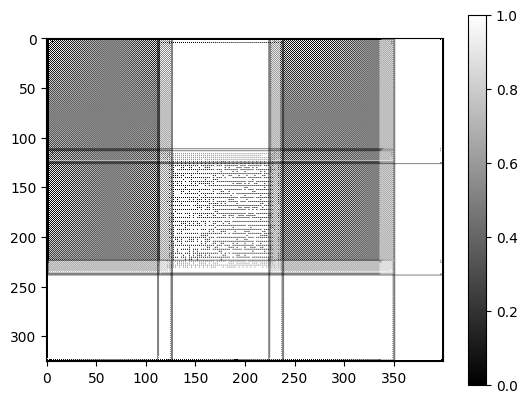

In [56]:
import matplotlib.pyplot as plt
slice_2d = image_output[:, :, 50]  # Assuming you want to visualize the first channel

# Convert the tensor to a NumPy array for visualization
slice_np = slice_2d.cpu().detach().numpy()

# Plot the 2D slice
plt.imshow(slice_np, cmap='gray')  # You can change the colormap as needed
plt.colorbar()
plt.show()

In [80]:
slice_2d.max()

tensor(2.6023, device='cuda:0')

In [32]:
target.shape

(128, 128, 128)

In [57]:
name

'PETCT_802f19931c_06302002'

2023-09-15 11:00:05 ===> locator: <matplotlib.ticker.AutoLocator object at 0x7f8ecbf4da20>


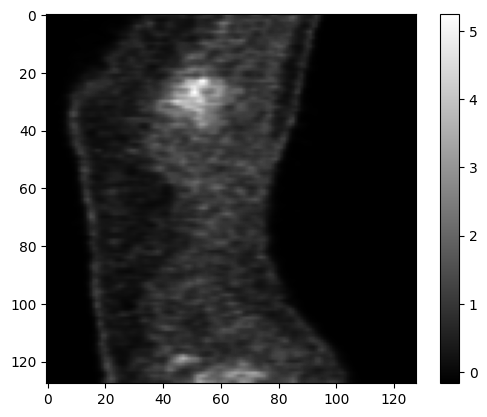

In [87]:
# view input images
import matplotlib.pyplot as plt
import matplotlib

slice_2d = x[0, 1, :, :, 10]  # Assuming you want to visualize the first channel

# Convert the tensor to a NumPy array for visualization
#slice_np = slice_2d.cpu().detach().numpy()

# Plot the 2D slice
plt.imshow(slice_np, cmap='gray')  # You can change the colormap as needed
plt.colorbar()
plt.show()

In [60]:
target.type

AttributeError: 'numpy.ndarray' object has no attribute 'type'

2023-09-15 10:33:10 ===> locator: <matplotlib.ticker.AutoLocator object at 0x7f8ecbe521a0>


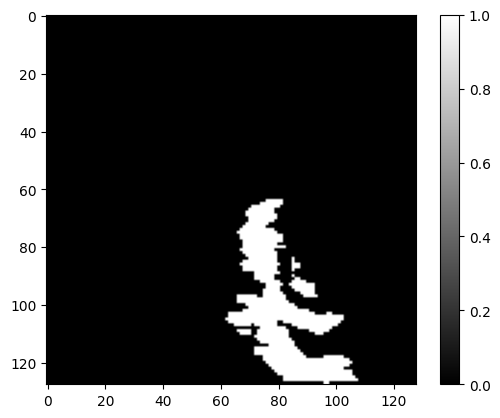

In [54]:
slice_2d = target[:, :, 10]  # Assuming you want to visualize the first channel

# Convert the tensor to a NumPy array for visualization
#slice_np = slice_2d.cpu().detach().numpy()

# Plot the 2D slice
plt.imshow(slice_2d, cmap='gray')  # You can change the colormap as needed
plt.colorbar()
plt.show()

2023-09-15 10:29:40 ===> locator: <matplotlib.ticker.AutoLocator object at 0x7f8eec2ecb80>


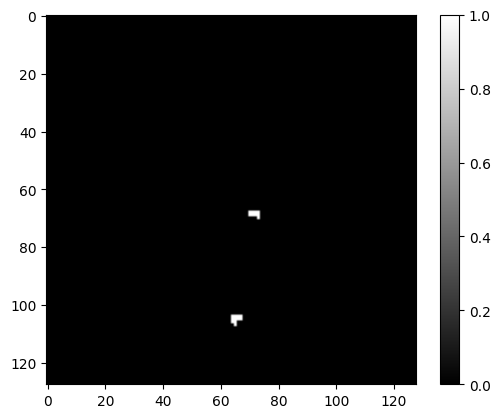

In [49]:
slice_2d = output[:, :, 10]  # Assuming you want to visualize the first channel

# Convert the tensor to a NumPy array for visualization
#slice_np = slice_2d.cpu().detach().numpy()

# Plot the 2D slice
plt.imshow(slice_2d, cmap='gray')  # You can change the colormap as needed
plt.colorbar()
plt.show()

In [62]:
uncertainty.shape

torch.Size([1, 1, 128, 128, 128])

2023-09-15 10:31:35 ===> locator: <matplotlib.ticker.AutoLocator object at 0x7f8ecbf777c0>


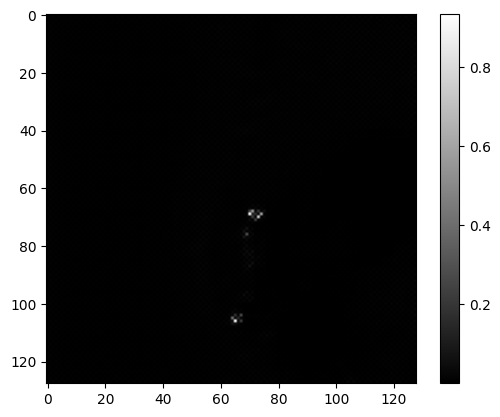

In [53]:
slice_2d = uncertainty[0, 0, :, :, 10]  # Assuming you want to visualize the first channel

# Convert the tensor to a NumPy array for visualization
slice_np = slice_2d.cpu().detach().numpy()

# Plot the 2D slice
plt.imshow(slice_np, cmap='gray')  # You can change the colormap as needed
plt.colorbar()
plt.show()

In [46]:
slice_2d

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])